#0. SDF Dataset: `bunny`

In [ ]:
# List files to ensure `bunny.tar.gz` is present
!ls

# Create a directory for the bunny dataset
!mkdir -p bunny_data

# Extract the tar.gz file into the bunny_data directory
!tar -xvzf bunny.tar.gz -C bunny_data

bunny.tar.gz  sample_data
bunny/
bunny/data/
bunny/data/README
bunny/data/bun.conf
bunny/data/bun.conf~
bunny/data/bun000.ply
bunny/data/bun045.ply
bunny/data/bun090.ply
bunny/data/bun180.ply
bunny/data/bun270.ply
bunny/data/bun315.ply
bunny/data/chin.ply
bunny/data/ear_back.ply
bunny/data/top2.ply
bunny/data/top3.ply
bunny/reconstruction/
bunny/reconstruction/README
bunny/reconstruction/bun_zipper.ply
bunny/reconstruction/bun_zipper_res2.ply
bunny/reconstruction/bun_zipper_res3.ply
bunny/reconstruction/bun_zipper_res4.ply


##0.1 Load the bunny mesh

Load the `bun_zipper.ply` mesh (the reconstructed file) using a 3D library like **Open3D**. This library is efficient for handling 3D meshes and point clouds.

In [ ]:
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.9 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninst

In [ ]:
import open3d as o3d

# Load the Bunny mesh (bun_zipper.ply)
mesh_path = "/content/bunny_data/bunny/reconstruction/bun_zipper.ply"
mesh = o3d.io.read_triangle_mesh(mesh_path)

#Print mesh info
print(mesh)

TriangleMesh with 35947 points and 69451 triangles.


In [ ]:
o3d.__version__

'0.18.0'

In [ ]:
#plotly comes installed by default in COLAB
#!pip install plotly

In [ ]:
# Visualize the Bunny mesh
# o3d.visualization.draw_geometries([mesh])
# #Sample points from the Bunny mesh
# pcd = mesh.sample_points_uniformly(number_of_points=10000)
# # Save the visualization as an HTML file
# o3d.io.write_triangle_mesh("bunny_visualization.html", mesh)
#print("Saved HTML visualization as 'bunny_visualization.html'")


#NOTE: Open3D visualization IS NOT SUPPORTED IN COLAB
#Lets use Plotly for Visualization


import plotly.graph_objects as go
import numpy as np

# Extract vertices and triangles
vertices = np.asarray(mesh.vertices)
triangles = np.asarray(mesh.triangles)

# Create a 3D plot using Plotly
fig = go.Figure(data=[
    go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=triangles[:, 0],
        j=triangles[:, 1],
        k=triangles[:, 2],
        color='lightblue',
        opacity=0.50
    )
])

fig.update_layout(
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Z"
    ),
    title="Stanford Bunny"
)
fig.show()

##0.2 Sample 3D Points in and Around the Bunny

To train your `SDF-NeRF` model, you need:

* 3D points inside and outside the Bunny.

* Their corresponding SDF values (positive outside, negative inside).

The SDF-NeRF model will learn the SDF function based on the provided data and gradients during training.
Even if the initial inside/outside split is imbalanced, the loss function (e.g., MSE for SDF values) and regularization (e.g., Eikonal loss) will help the model adapt.

In [ ]:
import numpy as np
import open3d as o3d

def prepare_sdf_data(mesh_path, num_points=1000):
    """
    Prepares SDF data by computing points and their signed distances from the mesh.

    Parameters:
    mesh_path (str): Path to the mesh file.
    num_points (int): Number of random points to sample within the mesh's bounding box.

    Returns:
    dict: A configuration dictionary with points, sdf_values, and other parameters.
    """
    # Load mesh and compute bounding box
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    bbox = mesh.get_axis_aligned_bounding_box()

    # Sample random points within the bounding box
    points_random = np.random.uniform(bbox.min_bound, bbox.max_bound, size=(num_points, 3))

    # Compute SDF values using raycasting
    scene = o3d.t.geometry.RaycastingScene()
    scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))
    points_tensor = o3d.core.Tensor(points_random, dtype=o3d.core.Dtype.Float32)

    distances = scene.compute_distance(points_tensor)
    inside = distances.numpy() < 1e-3  # Tolerance for "inside"

    #sdf_values = distances.copy()
    #sdf_values[distances < 1e-3] *= -1  # Negative for points inside the mesh

    # Count the number of points inside and outside
    num_inside = np.sum(inside)  # Number of points inside the mesh
    num_outside = len(inside) - num_inside  # Number of points outside the mesh

    # Calculate SDF values
    sdf_values = distances.numpy()  # Distances from points to the mesh surface
    sdf_values[inside] *= -1  # Negative SDF for inside points

    # Print results
    #print(f"Number of points inside the mesh: {num_inside}")
    #print(f"Number of points outside the mesh: {num_outside}")
    #print(f"SDF Value Range: Min {sdf_values.min()}, Max {sdf_values.max()}")

    # Return configuration dictionary
    return {
        "points_random": points_random,
        "sdf_values": sdf_values,
           }

result = prepare_sdf_data(mesh_path)
points_random = result["points_random"]
sdf_values = result["sdf_values"]

#WRONG:
#prepare_sdf_data["points_random"]


In [ ]:
#import numpy as np

# # Compute bounding box of the Bunny
# bbox = mesh.get_axis_aligned_bounding_box()
# print(f"The bunny bounding box:\n {bbox}\n")

# # Sample random points within the bounding box
# num_points = 1000  # Total number of points
# points_random = np.random.uniform(
#     low=bbox.min_bound, high=bbox.max_bound, size=(num_points, 3)
# )

# Use Open3D to calculate distances from points to the Bunny surface
#pcd = mesh.sample_points_uniformly(number_of_points=50000)  # Sample points (point cloud data) on the surface
#distances = np.asarray(pcd.compute_point_cloud_distance(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points_random))))

# Assign negative SDF values for points inside the Bunny
#sdf_values = distances.copy()

# the TriangleMesh object in Open3D does not have an is_point_inside method.
# inside = mesh.is_point_inside(points_random)
# sdf_values[inside] *= -1  # Inside points have negative SDF

#To determine whether points are inside a mesh, you can use the ray-casting algorithm. Open3D provides this functionality via the `open3d.geometry.TriangleMesh.create_raycasting_scene` method.

#Create a ray-casting scene from the Bunny mesh
# scene = o3d.t.geometry.RaycastingScene()
# mesh_id = scene.add_triangles(o3d.t.geometry.TriangleMesh.from_legacy(mesh))

# Check if points are inside the mesh
# points_tensor = o3d.core.Tensor(points_random, dtype=o3d.core.Dtype.Float32)
# distances = scene.compute_distance(points_tensor)

# Points with zero distance are inside the mesh
#inside = distances.numpy() < 1e-3  # Tolerance for "inside"

# Count the number of points inside and outside
# num_inside = np.sum(inside)  # Number of points inside the mesh
# num_outside = len(inside) - num_inside  # Number of points outside the mesh

# # Print results
# print(f"Number of points inside the mesh: {num_inside}")
# print(f"Number of points outside the mesh: {num_outside}")

The bunny bounding box:
 AxisAlignedBoundingBox: min: (-0.0946899, 0.0329874, -0.0618736), max: (0.0610091, 0.187321, 0.0587997)

Number of points inside the mesh: 38
Number of points outside the mesh: 962


##0.3 Compute SDF values

Now that you’ve determined which points are inside the mesh:

* Assign negative SDF values to points inside the mesh.

* Assign positive SDF values to points outside the mesh.

In [ ]:
# Calculate SDF values
# sdf_values = distances.numpy()  # Distances from points to the mesh surface
# sdf_values[inside] *= -1  # Negative SDF for inside points

# # Check results
# print(f"Number of points inside the mesh: {np.sum(inside)}")
# print(f"SDF Value Range: Min {sdf_values.min()}, Max {sdf_values.max()}")

Number of points inside the mesh: 38
SDF Value Range: Min -0.0009990065591409802, Max 0.07452750205993652


## 0.4 Pre-processing: `BunnySDFDataset`

We need to convert the SDF values and the sampled 3D points into a format that can be easily loaded during training.

In [ ]:
import torch
from torch.utils.data import Dataset

class BunnySDFDataset(Dataset):
    def __init__(self, points, sdf_values):
        """
        Initialize the dataset with sampled points and their SDF values.

        Args:
        points (numpy.ndarray): Array of 3D points (num_points, 3).
        sdf_values (numpy.ndarray): Array of SDF values corresponding to the points (num_points,).
        """
        self.points = torch.tensor(points, dtype=torch.float32)
        self.sdf_values = torch.tensor(sdf_values, dtype=torch.float32)

    def __len__(self):
        return len(self.points) #self.points

    def __getitem__(self, idx):
        """
        Retrieve the 3D point and its SDF value at the given index.

        Args:
        idx (int): Index of the sample.

        Returns:
        dict: Dictionary containing 'coords' (3D point) and 'sdf' (SDF value).
        """
        return {
            "coords": self.points[idx],
            "sdf": self.sdf_values[idx]
        }

#test the class
# SDF_dataset = BunnySDFDataset(points=num_points,
#                               sdf_values=sdf_values)

SDF_dataset = BunnySDFDataset(points=points_random,
                              sdf_values=sdf_values)

len(SDF_dataset)
SDF_dataset[999]

{'coords': tensor([-0.0436,  0.1771, -0.0604]), 'sdf': tensor(0.0179)}

##0.5 Configuration

In [ ]:
# config = {
#     "num_points" : points_random,
#     "sdf_values" : sdf_values,
#     "batch_size" : 1024,
#     "num_epochs" : 100,
#     "learning_rate" : 1e-4,
#     "device" : "cuda" if torch.cuda.is_available else "cpu",
#     "checkpoint_dir" : "checkpoints"
# }

##0.6 Initialize `dataset` & `dataloader`

In [ ]:
# from torch.utils.data import DataLoader

# dataset = BunnySDFDataset(points=config["num_points"],
#                           sdf_values=config["sdf_values"])

# dataloader = DataLoader(dataset = dataset,
#                         batch_size = config["batch_size"],
#                         shuffle = True)

# # Test the DataLoader
# sample_batch = next(iter(dataloader))
# print(f"Batch Coordinates Shape: {sample_batch['coords'].shape}")  # (batch_size, 3)
# print(f"Batch SDF Values Shape: {sample_batch['sdf'].shape}")      # (batch_size,)


#1. SDF Hashing `HashGridSDF()`

In [ ]:
import torch.nn as nn

#########
#DEFAULT#
#########

class HashGridSDF(nn.Module):
    def __init__(self, n_levels=16, n_features_per_level=2, log2_hashmap_size=19, base_resolution=16, finest_resolution=512):
        super().__init__()
        self.n_levels = n_levels
        self.n_features_per_level = n_features_per_level
        self.n_features = n_levels * n_features_per_level
        self.base_resolution = base_resolution
        self.finest_resolution = finest_resolution

        # Initialize hash tables
        self.hash_tables = nn.ModuleList([
            nn.Embedding(2**log2_hashmap_size, n_features_per_level)
            for _ in range(n_levels)
        ])
        for table in self.hash_tables:
            nn.init.uniform_(table.weight, -1e-4, 1e-4)

        # Compute level resolutions
        self.level_resolutions = [
            int(np.floor(base_resolution * np.exp(
                level * np.log(finest_resolution / base_resolution) / (n_levels - 1)
            ))) for level in range(n_levels)
        ]


    def hash_coords(self, coords, resolution):
        primes = torch.tensor([1, 2654435761, 805459861], device=coords.device)
        scaled_coords = coords * resolution
        coord_int = scaled_coords.long()
        hashed = (coord_int * primes).sum(dim=-1)
        return hashed % self.hash_tables[0].num_embeddings

    def forward(self, coords):
        # Ensure coords is the right shape (batch_size, 3)
        if coords.dim() == 3:
            coords = coords.squeeze(1)

        output_features = []
        for level, resolution in enumerate(self.level_resolutions):
            scaled_coords = coords * resolution
            coords_floor = torch.floor(scaled_coords)
            coords_frac = scaled_coords - coords_floor

            # Get all 8 corners of the cube
            corners = torch.stack([
                coords_floor + torch.tensor([i, j, k], device=coords.device)
                for i in [0, 1] for j in [0, 1] for k in [0, 1]
            ], dim=1)  # Shape: (batch_size, 8, 3)

            # Reshape corners for hashing
            corners_flat = corners.view(-1, 3)  # Shape: (batch_size * 8, 3)

            # Hash and get features for all corners
            hashed_indices = self.hash_coords(corners_flat, resolution)
            corner_features = self.hash_tables[level](hashed_indices)

            # Reshape corner features
            corner_features = corner_features.view(-1, 8, self.n_features_per_level)

            # Interpolate
            interpolated = self.trilinear_interpolate(corner_features, coords_frac)
            output_features.append(interpolated)

        return torch.cat(output_features, dim=-1)

    def trilinear_interpolate(self, features, coords_frac):
        # features: (batch_size, 8, feature_dim)
        # coords_frac: (batch_size, 3)

        x, y, z = coords_frac[..., 0], coords_frac[..., 1], coords_frac[..., 2]

        # Add singleton dimensions for broadcasting
        x = x.unsqueeze(-1)
        y = y.unsqueeze(-1)
        z = z.unsqueeze(-1)

        c000 = features[:, 0]  # (0,0,0)
        c001 = features[:, 1]  # (0,0,1)
        c010 = features[:, 2]  # (0,1,0)
        c011 = features[:, 3]  # (0,1,1)
        c100 = features[:, 4]  # (1,0,0)
        c101 = features[:, 5]  # (1,0,1)
        c110 = features[:, 6]  # (1,1,0)
        c111 = features[:, 7]  # (1,1,1)

        # Interpolation along x
        c00 = c000 * (1 - x) + c100 * x
        c01 = c001 * (1 - x) + c101 * x
        c10 = c010 * (1 - x) + c110 * x
        c11 = c011 * (1 - x) + c111 * x

        # Interpolation along y
        c0 = c00 * (1 - y) + c10 * y
        c1 = c01 * (1 - y) + c11 * y

        # Interpolation along z
        c = c0 * (1 - z) + c1 * z

        return c

In [ ]:
# class HashGridSDF(nn.Module):
#     def __init__(self, n_levels=16, n_features_per_level=2, log2_hashmap_size=19, base_resolution=16, finest_resolution=512, bbox_min=-1.0, bbox_max=1.0):
#         super().__init__()
#         self.n_levels = n_levels
#         self.n_features_per_level = n_features_per_level
#         self.n_features = n_levels * n_features_per_level
#         self.base_resolution = base_resolution
#         self.finest_resolution = finest_resolution
#         self.bbox_min = torch.tensor(bbox_min, dtype=torch.float32)
#         self.bbox_max = torch.tensor(bbox_max, dtype=torch.float32)

#         # Initialize hash tables
#         self.hash_tables = nn.ModuleList([
#             nn.Embedding(2**log2_hashmap_size, n_features_per_level)
#             for _ in range(n_levels)
#         ])
#         for table in self.hash_tables:
#             nn.init.uniform_(table.weight, -1e-4, 1e-4)

#         # Compute level resolutions
#         self.level_resolutions = [
#             int(np.floor(base_resolution * np.exp(
#                 level * np.log(finest_resolution / base_resolution) / (n_levels - 1)
#             ))) for level in range(n_levels)
#         ]

#     def normalize_coords(self, coords):
#         """
#         Normalize coordinates to the range [-1, 1] based on the bounding box.

#         Parameters:
#         coords (torch.Tensor): Input coordinates of shape (batch_size, 3).

#         Returns:
#         torch.Tensor: Normalized coordinates of shape (batch_size, 3).
#         """
#         return 2.0 * (coords - self.bbox_min) / (self.bbox_max - self.bbox_min) - 1.0

#     def hash_coords(self, coords, resolution):
#         primes = torch.tensor([1, 2654435761, 805459861], device=coords.device)
#         scaled_coords = coords * resolution
#         coord_int = scaled_coords.long()
#         hashed = (coord_int * primes).sum(dim=-1)
#         return hashed % self.hash_tables[0].num_embeddings

#     def forward(self, coords):
#         # Ensure coords is the right shape (batch_size, 3)
#         if coords.dim() == 3:
#             coords = coords.squeeze(1)

#         # Normalize coordinates
#         coords = self.normalize_coords(coords)

#         output_features = []
#         for level, resolution in enumerate(self.level_resolutions):
#             scaled_coords = coords * resolution
#             coords_floor = torch.floor(scaled_coords)
#             coords_frac = scaled_coords - coords_floor

#             # Get all 8 corners of the cube
#             corners = torch.stack([
#                 coords_floor + torch.tensor([i, j, k], device=coords.device)
#                 for i in [0, 1] for j in [0, 1] for k in [0, 1]
#             ], dim=1)  # Shape: (batch_size, 8, 3)

#             # Reshape corners for hashing
#             corners_flat = corners.view(-1, 3)  # Shape: (batch_size * 8, 3)

#             # Hash and get features for all corners
#             hashed_indices = self.hash_coords(corners_flat, resolution)
#             corner_features = self.hash_tables[level](hashed_indices)

#             # Reshape corner features
#             corner_features = corner_features.view(-1, 8, self.n_features_per_level)

#             # Interpolate
#             interpolated = self.trilinear_interpolate(corner_features, coords_frac)
#             output_features.append(interpolated)

#         return torch.cat(output_features, dim=-1)

#     def trilinear_interpolate(self, features, coords_frac):
#         # features: (batch_size, 8, feature_dim)
#         # coords_frac: (batch_size, 3)

#         x, y, z = coords_frac[..., 0], coords_frac[..., 1], coords_frac[..., 2]

#         # Add singleton dimensions for broadcasting
#         x = x.unsqueeze(-1)
#         y = y.unsqueeze(-1)
#         z = z.unsqueeze(-1)

#         c000 = features[:, 0]  # (0,0,0)
#         c001 = features[:, 1]  # (0,0,1)
#         c010 = features[:, 2]  # (0,1,0)
#         c011 = features[:, 3]  # (0,1,1)
#         c100 = features[:, 4]  # (1,0,0)
#         c101 = features[:, 5]  # (1,0,1)
#         c110 = features[:, 6]  # (1,1,0)
#         c111 = features[:, 7]  # (1,1,1)

#         # Interpolation along x
#         c00 = c000 * (1 - x) + c100 * x
#         c01 = c001 * (1 - x) + c101 * x
#         c10 = c010 * (1 - x) + c110 * x
#         c11 = c011 * (1 - x) + c111 * x

#         # Interpolation along y
#         c0 = c00 * (1 - y) + c10 * y
#         c1 = c01 * (1 - y) + c11 * y

#         # Interpolation along z
#         c = c0 * (1 - z) + c1 * z

#         return c


#2. NeRF-like `SDFNetwork`

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class SDFNeRFNetwork(nn.Module):
  def __init__(self, hash_encoder: HashGridSDF, D=8, W=64, skips=[4]):
    super().__init__()
    self.hash_encoder = hash_encoder
    self.D = D # Number of layers in the MLP
    self.W = W # Number of neurons in each layer
    self.input_ch = hash_encoder.n_features # Input features from HashGridSDF
    self.skips = skips

    #Define MLP block with skip connections
    self.layers = nn.ModuleList()
    #print(f"Length of input_ch:\n {self.input_ch}\n")
    self.layers.append(nn.Linear(self.input_ch, self.W)) # First layer
    for i in range(1, self.D):
      if i in self.skips:
        self.layers.append(nn.Linear(self.W + self.input_ch, self.W))  # Skip connection
      else:
        self.layers.append(nn.Linear(self.W, self.W)) # Regular layer

    #Output layer for SDF
    self.output_layer = nn.Linear(self.W, 1)

  def forward(self, x):
    #print("Input to forward:", x.shape)
    features = self.hash_encoder(x) # Encode input 3D points
    #print("Features shape:", features.shape)

    h = features
    #print(f"features:\n {h.shape}")
    for i, layer in enumerate(self.layers):
      #h = F.relu(layer(h)) # Apply ReLU activation
      if i in self.skips:
        h = torch.cat([features, h], dim=-1) # Skip connection
        #print(f"After skip connection at Layer {i}, shape:", h.shape)
      h = F.relu(layer(h)) # Apply ReLU activation
      #print(f"Layer {i} output shape:", h.shape)
    #One SDF value per input point
    sdf = self.output_layer(h) # Predict SDF value; SDF has shape (batch_size, 1)
    #print(f"SDF tensor is:\n {sdf.shape}\n")
    return sdf #return print() evaluates to None. #print(f"SDF tensor is:\n {sdf.shape}\n")

  def get_sdf_gradient(self, x, epsilon=1e-4):
    """
    Compute the gradient of the SDF with respect to the input coordinates.
    Args:
        x: Input tensor of shape (batch_size, 3) representing 3D coordinates.
    Returns:
        grad: Gradient tensor of shape (batch_size, 3).
    """
    with torch.enable_grad():
      # # Ensure `x` is on the same device as the model
      # x = x.to(next(self.parameters()).device)

      x.requires_grad_(True) # Enable gradient computation for the input
      #print(f"Input before forward pass:\n {x.shape}")
      sdf = self.forward(x) # Compute SDF for the input
      #print(sdf)
      grad = torch.autograd.grad(
          outputs=sdf.sum(),  # Sum is used to create a scalar loss
          inputs=x,
          create_graph=True, # Retain the computational graph for higher-order gradients
          retain_graph=True
      )[0] # The gradient of sdf.sum() with respect to x
    return grad

######################
# TEST FORWARD METHOD
######################

# hash_encoder = HashGridSDF()
# model = SDFNetwork(hash_encoder)

# # Ensure coords is the right shape (batch_size, 3)
# coords = torch.randn(2, 3)

# forward_pass = model(coords)

##############################
# TEST get_sdf_gradient METHOD
##############################

# hash_encoder = HashGridSDF()
# model = SDFNetwork(hash_encoder)

# # Ensure coords is the right shape (batch_size, 3)
# coords = torch.randn(2, 3)
# sdf_grad = model.get_sdf_gradient(coords)
# print("SDF Gradient Shape:", sdf_grad.shape)
# print("SDF Gradient Values:", sdf_grad)

#3. Train

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR
import os

def train_sdf_model(model, train_loader, num_epochs=100, lr=1e-4, device='cuda', checkpoint_dir='checkpoints'):
    os.makedirs(checkpoint_dir, exist_ok=True)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = ExponentialLR(optimizer, gamma=0.1**(1/num_epochs))

    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            coords = batch['coords'].to(device)
            sdf_gt = batch['sdf'].to(device)

            sdf_pred = model(coords).squeeze()
            grad = model.get_sdf_gradient(coords)
            grad_norm = torch.norm(grad, dim=-1)

            sdf_loss = F.mse_loss(sdf_pred, sdf_gt)
            eikonal_loss = F.mse_loss(grad_norm, torch.ones_like(grad_norm))
            loss = sdf_loss + 0.1 * eikonal_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.6f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))

        scheduler.step()

    return model

#4. Visualize SDF slice

In [ ]:
import torch
import matplotlib.pyplot as plt

############
# DEFAULT
############

def visualize_sdf_slice(model, resolution=100, z_value=0.0, device='cuda'):
    model.eval()
    x = torch.linspace(-1, 1, resolution)
    y = torch.linspace(-1, 1, resolution)
    xx, yy = torch.meshgrid(x, y)
    points = torch.stack([xx.flatten(), yy.flatten(), torch.ones_like(xx.flatten()) * z_value], dim=-1).to(device)

    with torch.no_grad():
        sdf_values = model(points).cpu().numpy().reshape(resolution, resolution)

    plt.figure(figsize=(10, 10))
    plt.imshow(sdf_values, extent=[-1, 1, -1, 1], cmap='RdBu')
    plt.colorbar(label='SDF Value')
    plt.title(f'SDF Slice at z={z_value}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

##############
# FIRST DRAFT
##############


# def visualize_sdf_slice(model, mesh, resolution=200, device='cuda'):
#     """
#     Visualize a slice of the SDF at a meaningful z-value.

#     Parameters:
#     model (nn.Module): The trained SDF model.
#     mesh (open3d.geometry.TriangleMesh): The Bunny mesh for bounding box reference.
#     resolution (int): Resolution of the grid.
#     device (str): Device to run the computation ('cuda' or 'cpu').
#     """
#     model.eval()

#     # Get Bunny bounding box
#     bbox_min = mesh.get_min_bound()
#     bbox_max = mesh.get_max_bound()

#     # Adjust x, y ranges to fit the Bunny
#     x = torch.linspace(bbox_min[0], bbox_max[0], resolution)
#     y = torch.linspace(bbox_min[1], bbox_max[1], resolution)
#     xx, yy = torch.meshgrid(x, y)

#     # Use z-value at the center of the bounding box
#     z_value = (bbox_min[2] + bbox_max[2]) / 2

#     # Create points in the slice
#     points = torch.stack([xx.flatten(), yy.flatten(), torch.ones_like(xx.flatten()) * z_value], dim=-1).to(device)

#     # Predict SDF values for the slice
#     with torch.no_grad():
#         sdf_values = model(points).cpu().numpy().reshape(resolution, resolution)

#     # Plot the slice
#     plt.figure(figsize=(10, 10))
#     plt.imshow(sdf_values, extent=[bbox_min[0], bbox_max[0], bbox_min[1], bbox_max[1]], cmap='RdBu', origin='lower')
#     plt.colorbar(label='SDF Value')
#     plt.title(f'SDF Slice at z={z_value:.2f}')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.show()

###############
# SECOND DRAFT
###############

# def visualize_sdf_slice(model, mesh, resolution=200, z_value=None, device='cuda'):
#     """
#     Visualize a slice of the SDF at a meaningful z-value.

#     Parameters:
#     model (nn.Module): The trained SDF model.
#     mesh (open3d.geometry.TriangleMesh): The Bunny mesh for bounding box reference.
#     resolution (int): Resolution of the grid.
#     z_value (float): Z-coordinate for the slice (defaults to the center of the mesh).
#     device (str): Device to run the computation ('cuda' or 'cpu').
#     """
#     model.eval()

#     # Get Bunny bounding box
#     bbox_min = mesh.get_min_bound()
#     bbox_max = mesh.get_max_bound()

#     # Adjust x, y ranges to fit the Bunny
#     x = torch.linspace(bbox_min[0], bbox_max[0], resolution)
#     y = torch.linspace(bbox_min[1], bbox_max[1], resolution)
#     xx, yy = torch.meshgrid(x, y)

#     # Use default z-value if not provided
#     if z_value is None:
#         z_value = bbox_min[2] + 0.5 * (bbox_max[2] - bbox_min[2])

#     # Create points in the slice
#     points = torch.stack([xx.flatten(), yy.flatten(), torch.ones_like(xx.flatten()) * z_value], dim=-1).to(device)

#     # Predict SDF values for the slice
#     with torch.no_grad():
#         sdf_values = model(points).cpu().numpy().reshape(resolution, resolution)

#     # Normalize SDF values
#     sdf_values = (sdf_values - sdf_values.min()) / (sdf_values.max() - sdf_values.min())

#     # Plot the slice
#     plt.figure(figsize=(10, 10))
#     plt.imshow(sdf_values, extent=[bbox_min[0], bbox_max[0], bbox_min[1], bbox_max[1]], cmap='coolwarm', origin='lower')
#     plt.colorbar(label='Normalized SDF Value')
#     plt.title(f'SDF Slice at z={z_value:.2f}')
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.show()



#5. Main

In [ ]:
# #Load the Bunny mesh
# mesh_path = "/content/bunny_data/bunny/reconstruction/bun_zipper.ply"
# mesh = o3d.io.read_triangle_mesh(mesh_path)

# # Compute the axis-aligned bounding box
# bbox = mesh.get_axis_aligned_bounding_box()

# Configuration
config = {
    "mesh_path" : "/content/bunny_data/bunny/reconstruction/bun_zipper.ply",
    "num_points": 1000,  # Total number of random points to generate
    "batch_size": 1024,
    "num_epochs": 100,
    "learning_rate": 1e-4,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_dir": "checkpoints"
}

# # Sample random points within the bounding box using config["num_points"]
# points_random = np.random.uniform(
#     low=bbox.min_bound, high=bbox.max_bound, size=(config["num_points"], 3)
# )

# Generate SDF data
sdf_data = prepare_sdf_data(config["mesh_path"], config["num_points"])

# Update config with SDF data
config.update(sdf_data)

# Initialize dataset & dataloader

from torch.utils.data import DataLoader

dataset = BunnySDFDataset(points=config["points_random"],
                          sdf_values=config["sdf_values"])

dataloader = DataLoader(dataset = dataset,
                        batch_size = config["batch_size"],
                        shuffle = True)

# Test the DataLoader
sample_batch = next(iter(dataloader))
print(f"Batch Coordinates Shape: {sample_batch['coords'].shape}")  # (batch_size, 3)
print(f"Batch SDF Values Shape: {sample_batch['sdf'].shape}")      # (batch_size,)


Batch Coordinates Shape: torch.Size([1000, 3])
Batch SDF Values Shape: torch.Size([1000])


In [ ]:
#Number of points
len(SDF_dataset)

1000

In [ ]:
#Initialize SDF Hashing
hash_encoder = HashGridSDF()

#Initialize model
model = SDFNeRFNetwork(hash_encoder)

#Train the model
trained_model = train_sdf_model(
    model=model,
    train_loader=dataloader,
    num_epochs=config["num_epochs"],
    lr=config["learning_rate"],
    device=config["device"],
    checkpoint_dir=config["checkpoint_dir"]
)

Epoch 1/100: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


Epoch 1, Loss: 0.101328


Epoch 2/100: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s]


Epoch 2, Loss: 0.100893


Epoch 3/100: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Epoch 3, Loss: 0.100720


Epoch 4/100: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


Epoch 4, Loss: 0.100421


Epoch 5/100: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


Epoch 5, Loss: 0.100124


Epoch 6/100: 100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


Epoch 6, Loss: 0.099828


Epoch 7/100: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


Epoch 7, Loss: 0.099531


Epoch 8/100: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch 8, Loss: 0.099463


Epoch 9/100: 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


Epoch 9, Loss: 0.099549


Epoch 10/100: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Epoch 10, Loss: 0.099332


Epoch 11/100: 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Epoch 11, Loss: 0.099107


Epoch 12/100: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]


Epoch 12, Loss: 0.098877


Epoch 13/100: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Epoch 13, Loss: 0.098642


Epoch 14/100: 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Epoch 14, Loss: 0.098404


Epoch 15/100: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


Epoch 15, Loss: 0.098163


Epoch 16/100: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


Epoch 16, Loss: 0.097918


Epoch 17/100: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


Epoch 17, Loss: 0.097670


Epoch 18/100: 100%|██████████| 1/1 [00:00<00:00,  6.22it/s]


Epoch 18, Loss: 0.097417


Epoch 19/100: 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]


Epoch 19, Loss: 0.097161


Epoch 20/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 20, Loss: 0.097289


Epoch 21/100: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


Epoch 21, Loss: 0.097053


Epoch 22/100: 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


Epoch 22, Loss: 0.096811


Epoch 23/100: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


Epoch 23, Loss: 0.096559


Epoch 24/100: 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]


Epoch 24, Loss: 0.096297


Epoch 25/100: 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


Epoch 25, Loss: 0.096036


Epoch 26/100: 100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


Epoch 26, Loss: 0.095778


Epoch 27/100: 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


Epoch 27, Loss: 0.095516


Epoch 28/100: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Epoch 28, Loss: 0.095252


Epoch 29/100: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


Epoch 29, Loss: 0.094983


Epoch 30/100: 100%|██████████| 1/1 [00:00<00:00,  6.33it/s]


Epoch 30, Loss: 0.094712


Epoch 31/100: 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


Epoch 31, Loss: 0.094445


Epoch 32/100: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


Epoch 32, Loss: 0.094172


Epoch 33/100: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


Epoch 33, Loss: 0.093891


Epoch 34/100: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s]


Epoch 34, Loss: 0.093607


Epoch 35/100: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


Epoch 35, Loss: 0.093320


Epoch 36/100: 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


Epoch 36, Loss: 0.093029


Epoch 37/100: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


Epoch 37, Loss: 0.092737


Epoch 38/100: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]


Epoch 38, Loss: 0.092441


Epoch 39/100: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


Epoch 39, Loss: 0.092145


Epoch 40/100: 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


Epoch 40, Loss: 0.091845


Epoch 41/100: 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


Epoch 41, Loss: 0.091545


Epoch 42/100: 100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


Epoch 42, Loss: 0.091241


Epoch 43/100: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


Epoch 43, Loss: 0.090935


Epoch 44/100: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]


Epoch 44, Loss: 0.090629


Epoch 45/100: 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


Epoch 45, Loss: 0.090321


Epoch 46/100: 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


Epoch 46, Loss: 0.090007


Epoch 47/100: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]


Epoch 47, Loss: 0.089698


Epoch 48/100: 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


Epoch 48, Loss: 0.089388


Epoch 49/100: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


Epoch 49, Loss: 0.089076


Epoch 50/100: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s]


Epoch 50, Loss: 0.088763


Epoch 51/100: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


Epoch 51, Loss: 0.088456


Epoch 52/100: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


Epoch 52, Loss: 0.088149


Epoch 53/100: 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


Epoch 53, Loss: 0.087845


Epoch 54/100: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s]


Epoch 54, Loss: 0.087535


Epoch 55/100: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


Epoch 55, Loss: 0.087232


Epoch 56/100: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]


Epoch 56, Loss: 0.086931


Epoch 57/100: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


Epoch 57, Loss: 0.086625


Epoch 58/100: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


Epoch 58, Loss: 0.086324


Epoch 59/100: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


Epoch 59, Loss: 0.086025


Epoch 60/100: 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]


Epoch 60, Loss: 0.085731


Epoch 61/100: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


Epoch 61, Loss: 0.085441


Epoch 62/100: 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]


Epoch 62, Loss: 0.085151


Epoch 63/100: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]


Epoch 63, Loss: 0.084865


Epoch 64/100: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s]


Epoch 64, Loss: 0.084582


Epoch 65/100: 100%|██████████| 1/1 [00:00<00:00,  6.60it/s]


Epoch 65, Loss: 0.084303


Epoch 66/100: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


Epoch 66, Loss: 0.084028


Epoch 67/100: 100%|██████████| 1/1 [00:00<00:00,  4.21it/s]


Epoch 67, Loss: 0.083757


Epoch 68/100: 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


Epoch 68, Loss: 0.083490


Epoch 69/100: 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


Epoch 69, Loss: 0.083223


Epoch 70/100: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


Epoch 70, Loss: 0.082958


Epoch 71/100: 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


Epoch 71, Loss: 0.082700


Epoch 72/100: 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


Epoch 72, Loss: 0.082442


Epoch 73/100: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


Epoch 73, Loss: 0.082191


Epoch 74/100: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]


Epoch 74, Loss: 0.081942


Epoch 75/100: 100%|██████████| 1/1 [00:00<00:00,  6.64it/s]


Epoch 75, Loss: 0.081696


Epoch 76/100: 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


Epoch 76, Loss: 0.081453


Epoch 77/100: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]


Epoch 77, Loss: 0.081216


Epoch 78/100: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


Epoch 78, Loss: 0.080980


Epoch 79/100: 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


Epoch 79, Loss: 0.080747


Epoch 80/100: 100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


Epoch 80, Loss: 0.080518


Epoch 81/100: 100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


Epoch 81, Loss: 0.080294


Epoch 82/100: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]


Epoch 82, Loss: 0.080072


Epoch 83/100: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]


Epoch 83, Loss: 0.079852


Epoch 84/100: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]


Epoch 84, Loss: 0.079637


Epoch 85/100: 100%|██████████| 1/1 [00:00<00:00,  6.45it/s]


Epoch 85, Loss: 0.079426


Epoch 86/100: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s]


Epoch 86, Loss: 0.079219


Epoch 87/100: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]


Epoch 87, Loss: 0.079015


Epoch 88/100: 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


Epoch 88, Loss: 0.078813


Epoch 89/100: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s]


Epoch 89, Loss: 0.078615


Epoch 90/100: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


Epoch 90, Loss: 0.078420


Epoch 91/100: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s]


Epoch 91, Loss: 0.078236


Epoch 92/100: 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


Epoch 92, Loss: 0.078048


Epoch 93/100: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


Epoch 93, Loss: 0.077868


Epoch 94/100: 100%|██████████| 1/1 [00:00<00:00,  6.69it/s]


Epoch 94, Loss: 0.077687


Epoch 95/100: 100%|██████████| 1/1 [00:00<00:00,  6.36it/s]


Epoch 95, Loss: 0.077509


Epoch 96/100: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]


Epoch 96, Loss: 0.077335


Epoch 97/100: 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


Epoch 97, Loss: 0.077164


Epoch 98/100: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


Epoch 98, Loss: 0.076999


Epoch 99/100: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


Epoch 99, Loss: 0.076834


Epoch 100/100: 100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


Epoch 100, Loss: 0.076673


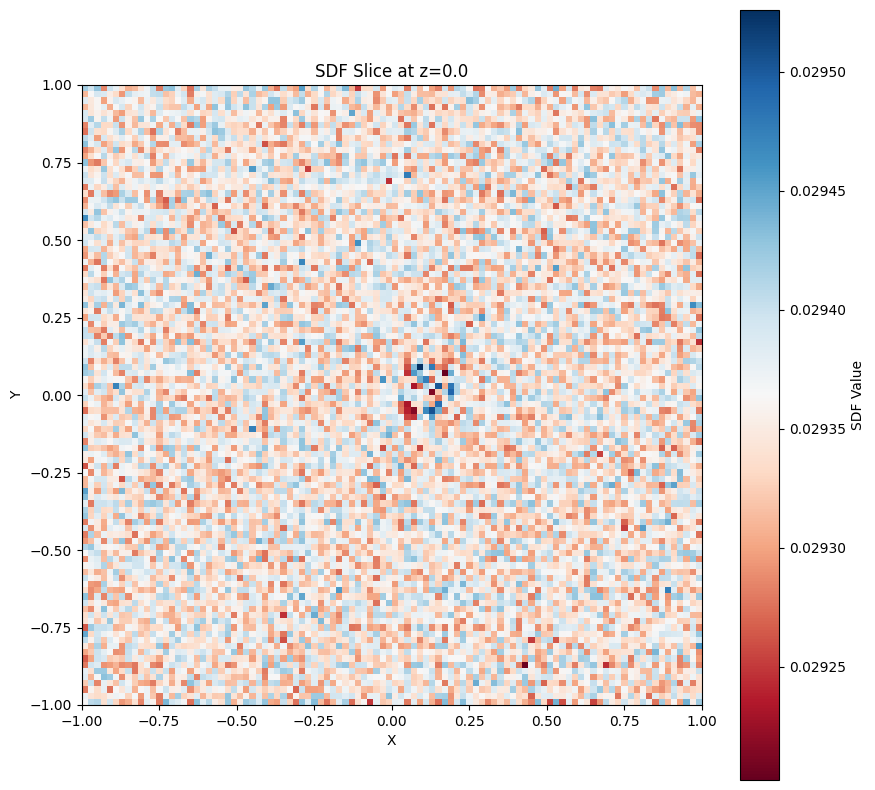

In [ ]:
visualize_sdf_slice(trained_model)

###Dummy dataset

Let's create a dummy dataset to verify whether `visualize_sdf_slice` works out

In [ ]:
import torch
import torch.nn as nn

class DummySDFModel(nn.Module):
    def __init__(self, sphere_radius=0.5):
        super().__init__()
        self.sphere_radius = sphere_radius

    def forward(self, points):
        """
        Compute SDF for a sphere centered at the origin.

        Parameters:
        points (torch.Tensor): Input points of shape (batch_size, 3).

        Returns:
        torch.Tensor: SDF values of shape (batch_size, 1).
        """
        distances = torch.norm(points, dim=-1, keepdim=True)  # Compute distance to origin
        sdf = distances - self.sphere_radius  # Signed distance to sphere surface
        return sdf


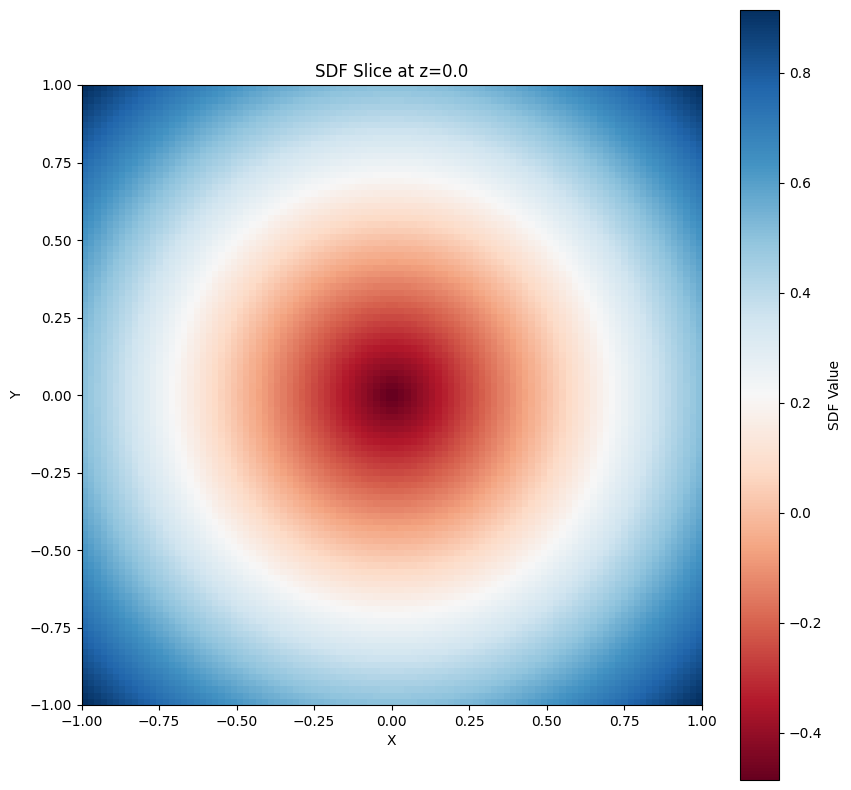

In [ ]:
# Create a dummy SDF model for a sphere with radius 0.5
dummy_model = DummySDFModel(sphere_radius=0.5).to('cuda')

# Visualize the SDF slice at z=0
visualize_sdf_slice(dummy_model, resolution=100, z_value=0.0, device='cuda')


It generates a perfect sphere. This suggests that the mistake must be somewhere else